# Getting started with PUDL
This notebook is meant to help get you up and running with the PUDL database, so you can play with it!

# Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and give them a nickname like `np` or `pd` to keep things simpler.

In [20]:
import sys
import os
import numpy as np
import pandas as pd

# Importing our own code
Assuming the data loading went well, now it's time to need to tell Python where to look to find our code. Python has a list of directories that it looks in by default, but our little project isn't in that list, because we're not yet ready to package it up for installation on a user's system.  So we need to tell Python exactly where to find it it. This is what `sys.path.append()` does in the code cell below. Right now this tells Python to look three directories above the current directory (`../../../` for the main PUDL module directory, which is what you got when you cloned our `git` repository. If you're running a notebook from a different directory, you'll need to change that path.

Once Python knows to look in the `pudl` project folder, it will let you import `pudl` modules just like any other Python module.  Here we're pulling in all the individual modules we've created so far, so everything is available to play with.

In [21]:
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923
from pudl import models, models_ferc1, models_eia923
from pudl import settings, constants

For Windows users: We need to add the location in which the pip package manager installed the Python modules needed for pudl (dbfread and postgres-copy) to the Python path in order for Python to import those modules as well. Replace `username` below with your Windows username.

In [ ]:
sys.path.append('c:/users/username/appdata/local/programs/python/python36-32/lib/site-packages')

# Connecting to our databases.
The FERC Form 1 (`ferc1`) database that you created above is just a temporary container used to migrate the Form 1 data out of the FoxPro database that FERC uses. The main database that all the data eventually lands in is (`pudl`). In order to grab a connection to the database, so you can pull data into this notebook, you can use the shorthand function below:

In [22]:
pudl_engine  = pudl.connect_db()

# Selecting data from within PUDL
Once you've got the `pudl_engine` created, there are several different ways you can use it to extract information from within the PUDL database. If you're already familiar with SQL, the easiest is probably to use the built-in pandas dataframe method `read_sql()`.

The `fuel_receipts_costs_eia923` table contains information about fuel deliveries to power plants in the US. It contains hundreds of thousands of records, currently covering 2009 to 2015.

In [23]:
frc_eia923 = pd.read_sql('''SELECT * FROM fuel_receipts_costs_eia923''', pudl_engine)

# What kind of data do we have here?
Once the dataframe has been populated with data from the database, we can look and see what all the fields (or columns) in the dataframe are called, giving us an indication of what the information is.

In [25]:
frc_eia923.columns

Index(['fuel_receipt_id', 'plant_id', 'report_date', 'contract_type',
       'contract_expiration_date', 'energy_source', 'fuel_group',
       'mine_id', 'supplier', 'fuel_quantity', 'average_heat_content',
       'average_sulfur_content', 'average_ash_content',
       'average_mercury_content', 'fuel_cost_per_mmbtu',
       'primary_transportation_mode', 'secondary_transportation_mode',
       'natural_gas_transport'],
      dtype='object')

# Organizing the pandas dataframes

Now that we've got a data frame filled with data we pulled out of our database, we can organize it however we want to do analysis or make figures. Just as an example, let's prepare the data to make a figure showing the distribution of fuel heat content per unit delivered for coal and natural gas.

First we create masks which allow us to subselect based on what kind of fuel each record reports.  Then we drop any records with NA values for `average_heat_content` and exclude any records that have a reported heat content of zero (or less).

In [26]:
coal_mask = frc_eia923['fuel_group'] == 'Coal'
coal_frc = frc_eia923[coal_mask]
coal_frc = coal_frc.dropna(subset=['average_heat_content'])
coal_frc = coal_frc[coal_frc.average_heat_content > 0]

gas_mask = frc_eia923['fuel_group'] == 'Natural Gas'
gas_frc  = frc_eia923[gas_mask]
gas_frc = gas_frc.dropna(subset=['average_heat_content'])
gas_frc = gas_frc[gas_frc.average_heat_content > 0]

# Plotting the data

With our coal and gas dataframes ready to go, now we can assemble a simple figure, and see what the heat content distributions look like using Matplotlib.

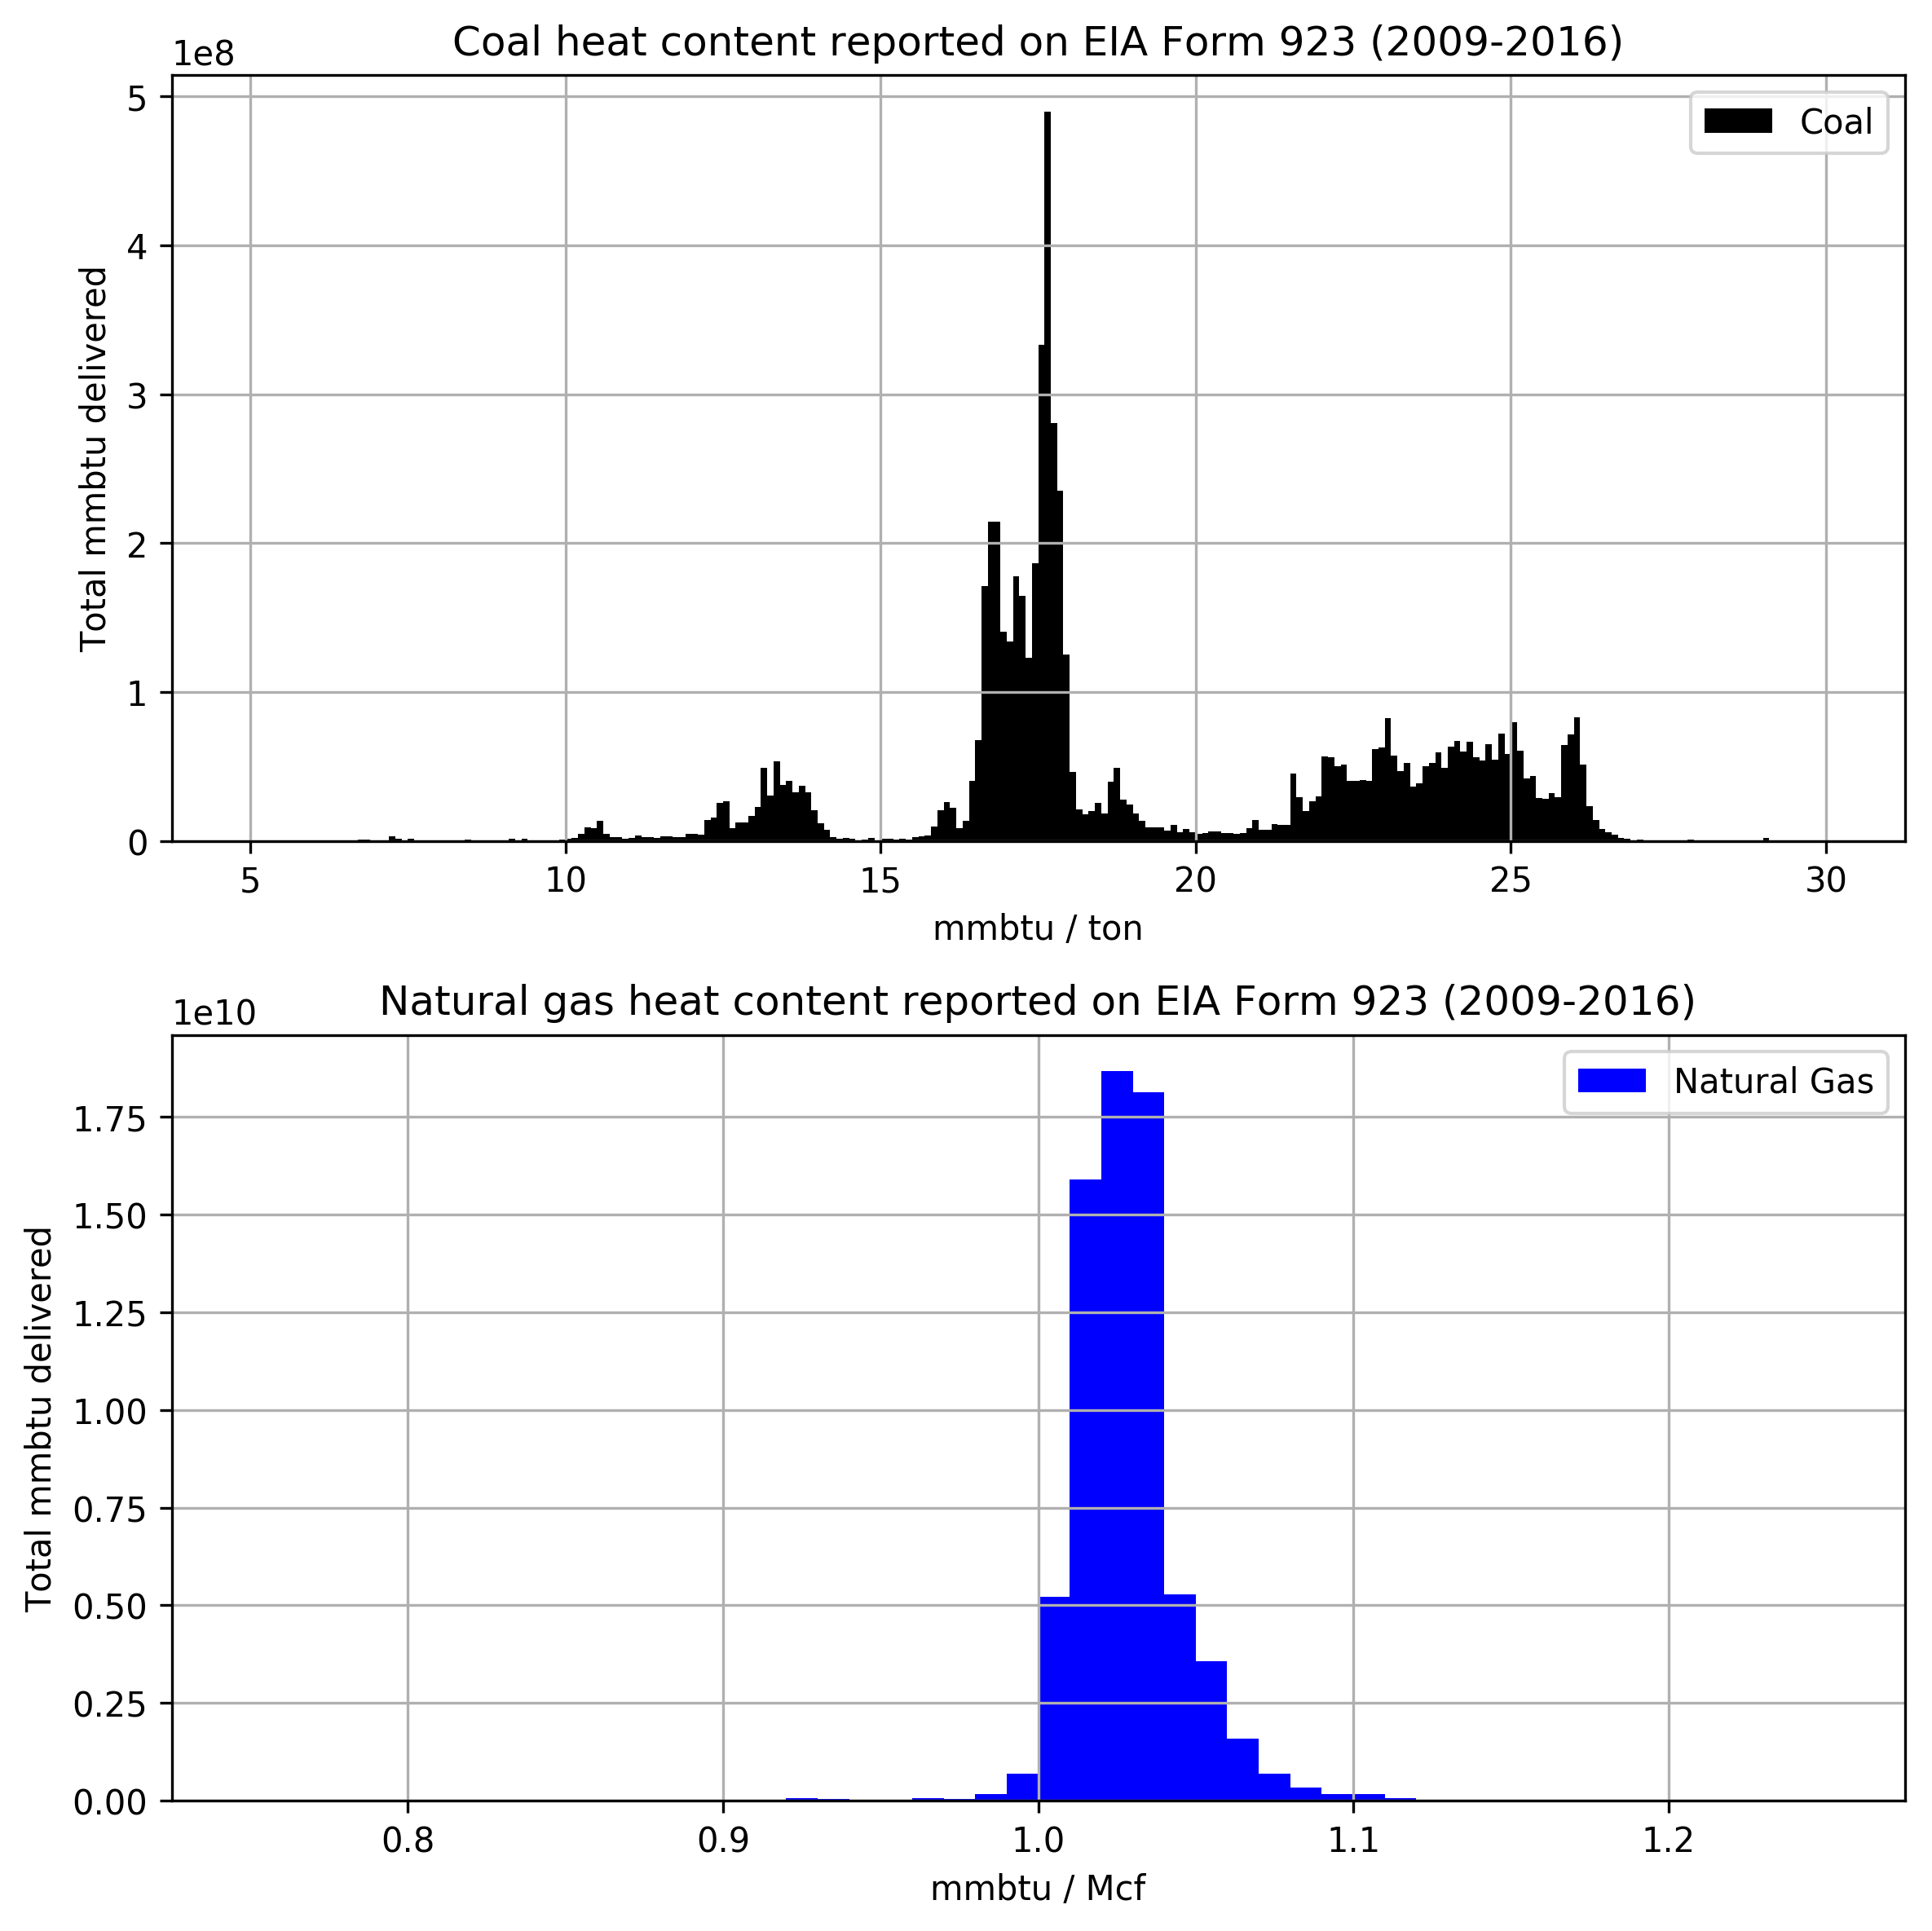

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (coal_ax, gas_ax) = plt.subplots(2)

fig.set_dpi(300)
fig.set_figwidth(8)
fig.set_figheight(8)

coal_ax.set_title("Coal heat content reported on EIA Form 923 (2009-2016)")
coal_ax.grid()
coal_ax.set_xlabel('mmbtu / ton')
coal_ax.set_ylabel('Total mmbtu delivered')
coal_ax.hist(coal_frc.average_heat_content, weights=coal_frc.fuel_quantity,
             bins=250, range=(5,30), label='Coal', color='black')
coal_ax.legend()

gas_ax.set_title("Natural gas heat content reported on EIA Form 923 (2009-2016)")
gas_ax.grid()
gas_ax.set_xlabel('mmbtu / Mcf')
gas_ax.set_ylabel('Total mmbtu delivered')
gas_ax.hist(gas_frc.average_heat_content, weights=gas_frc.fuel_quantity,
            bins=50, range=(0.75,1.25), label='Natural Gas', color='blue')
gas_ax.legend()

plt.tight_layout()
plt.show()